# CNN classifier

Congratulations, here's your first homework! You'll learn the art of training deep image classifiers. You might remember `03 seminar` about training CIFAR10 classifier, this homework is also about training **CIFAR10 classifier**, but this time you'll have to do it on your own and with some extra features.

## Data
Your dataset is CIFAR10. Check out `03 seminar` on how to load train and val data splits.

**Note:** for training you can only use `train` dataset.

## Game rules:
Maximum score you can get for this task is **10.0**.

Half of 10 points you can get by reaching high val accuracy (as listed in table below):

- accuracy > 60.0 -> **1 point**
- accuracy > 70.0 -> **2 points**
- accuracy > 80.0 -> **3 points**
- accuracy > 90.0 -> **4 points**
- accuracy > 92.5 -> **5 points**

Another half of 10 points you can get by adding following features to your training pipeline. It's okay if you see some technics for the first time (that was the idea). Feel free to google and dive into topic on your own, it's homework after all:
1. Data augmentations. Check out [this article](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced) (**1 point**)
2. [LR schedule](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau) (**0.5 point**)
3. Finetune pretrained model from [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html) (except AlexNet!) (**1 point**)
4. Implement [ResNet model](https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624) (**2 points**)
5. Use of [tensorboardX](https://github.com/lanpa/tensorboardX) to monitor training process (**0.5 points**)

As a result you have to submit **notebook with working code** (results will be reproduced during homework cheking) and **short report** (write it in the same notebook) about things you tried and what tasks you managed to implement. Good luck and have fun!

# Loading and normalizing CIFAR10
Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from tensorboardX import SummaryWriter

In [2]:
import numpy as np
from tqdm import tqdm_notebook, tqdm

Parameters:

In [3]:
batch_size = 4
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

CIFAR10 classes:

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

## Добавим аугментацию изображений

За основу был взят ноутбук: https://colab.research.google.com/drive/109vu3F1LTzD1gdVV6cho9fKGx7lzbFll#scrollTo=aFtwoTIS0woY

In [5]:
# !pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia

In [6]:
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0, .75))),
            iaa.Fliplr(0.5),
            iaa.Affine(rotate=(-15, 15), mode='symmetric'),
            iaa.Sometimes(0.2, iaa.OneOf([
                iaa.Dropout(p=(0, 0.025)),
                iaa.CoarseDropout(0.02, size_percent=0.05),
            ])),
            iaa.AddToHueAndSaturation(value=(-5, 5), per_channel=True),
        ])

    def __call__(self, img):
        img = np.array(img)
        return np.ascontiguousarray(self.aug.augment_image(img))

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range ~[-1, 1]. This weird numbers are just means and stds calculated on ImageNet (check [this docs](https://pytorch.org/docs/master/torchvision/models.html) for more information).

In [7]:
transform = transforms.Compose([
    transforms.Resize(299),
    ImgAugTransform(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
#     transforms.ToPILImage(),
])

Setup dataloaders (downloading CIFAR10 can take some time):

In [8]:
%%time
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print("len(train_dataset) =", len(train_dataset))

val_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
val_dataloader= torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("len(val_dataset) =", len(val_dataset))

Files already downloaded and verified
len(train_dataset) = 50000
Files already downloaded and verified
len(val_dataset) = 10000
CPU times: user 1.51 s, sys: 430 ms, total: 1.94 s
Wall time: 2.08 s


Let us show some of the training images, for fun:

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = (15, 25)


def unnorm(img):
    img = np.array(img, dtype=float) / 2 + 0.5  # unnormalize
    img -= np.min(img)
    img /= np.max(img)
    return np.transpose(img, (1, 2, 0))

def show_dataset(dataset, n=3, m=6):
    img = np.vstack((np.hstack([unnorm(np.asarray(dataset[i][0])) for _ in range(m)]) for i in range(n)))
    plt.imshow(img)
    plt.axis('off')

/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


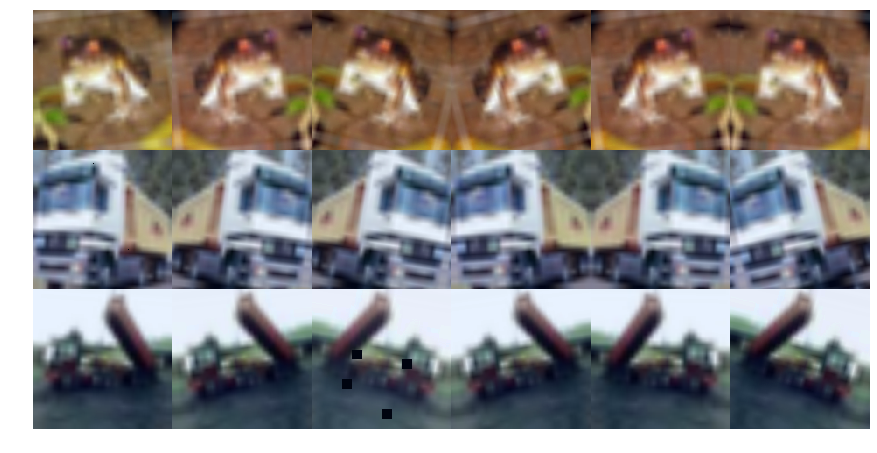

In [25]:
show_dataset(train_dataset)

# Inception_v3 finetune

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [15]:
from __future__ import print_function
from __future__ import division

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import os
import time
import copy
import numpy as np

from resnet import resnet50

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.0.1
Torchvision Version:  0.2.1


In [12]:
def train_model(
    model, dataloaders, criterion, optimizer, writer, num_epochs=25, is_inception=False, scheduler=None
):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    n_iter = {
        'train': 0,
        'val': 0,
    }

    for epoch in tqdm_notebook(range(num_epochs)):
        tqdm.write('Epoch {}/{}'.format(epoch, num_epochs - 1))
        tqdm.write('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm_notebook(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                batch_loss = loss.item() * inputs.size(0)
                batch_corrects = torch.sum(preds == labels.data)
                
                writer.add_scalar(f'{phase}/batch_loss', batch_loss, n_iter[phase])
                writer.add_scalar(f'{phase}/batch_corrects', batch_corrects, n_iter[phase])
                
                running_loss += batch_loss
                running_corrects += batch_corrects
                n_iter[phase] += 1
                writer.file_writer.flush()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
                
            writer.add_scalar(f'{phase}/epoch_loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase}/epoch_acc', epoch_acc, epoch)

            tqdm.write('{} Loss: {:.5f} Acc: {:.5f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                if scheduler is not None:
                    # Note that step should be called after validate()
                    scheduler.step(epoch_loss)
                # add images to tensorboard
                n_samples = 16
                for i in range(n_samples):
                    writer.add_image(
                        f'label={classes[labels.data[i]]}, pred={classes[preds[i]]}', 
                        torch.from_numpy(np.transpose(unnorm(inputs[i]), (2, 0, 1))).float(),
                        epoch
                    )
            
            writer.file_writer.flush()

    time_elapsed = time.time() - since
    tqdm.write('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    tqdm.write('Best val Acc: {:5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [13]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [19]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
    
    elif model_name == "resnet":
        
        model_ft = resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

Определим модель

Код был взят из: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

In [20]:
# model params
model_name = "resnet"
feature_extract = True

# train params
num_epochs = 10
batch_size = 32

# optimize params
lr = 0.001
decay_factor = 0.05
patience = 3
min_lr = 1e-6
verbose = True

log_dir = './logs_resnet/'

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

Настроим dataloader'ы

In [21]:
data_dir = './data'
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        ImgAugTransform(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {
    x: torchvision.datasets.CIFAR10(
        root=os.path.join(data_dir, x),
        train=(x == 'train'),
        download=True,
        transform=data_transforms[x]
    ) 
    for x in ['train', 'val']
}

# Create training and validation dataloaders
dataloaders_dict = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) 
    for x in ['train', 'val']
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...
Files already downloaded and verified
Files already downloaded and verified


Посмотрим как работает аугментация на train'е

/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


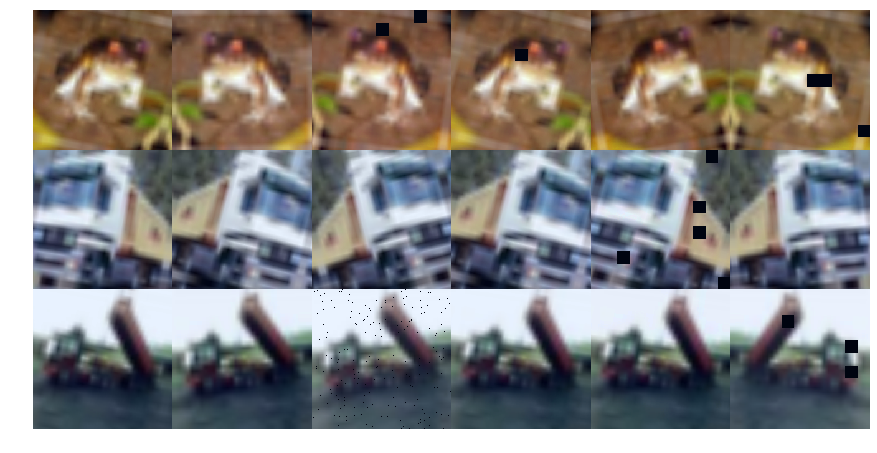

In [26]:
show_dataset(image_datasets['train'])

И проверим, что ее нет на val

/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


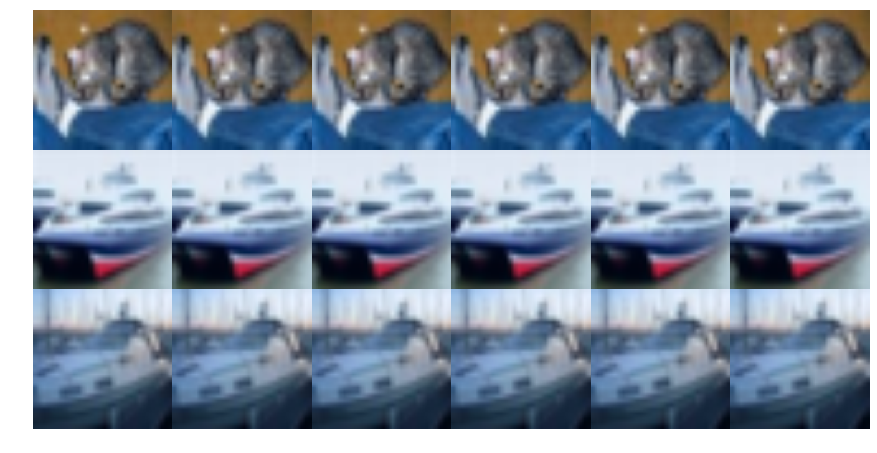

In [27]:
show_dataset(image_datasets['val'])

Зададим оптимизатор и укажем ему, какие параметры оптимизировать

In [28]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=lr)

Params to learn:
	 fc.weight
	 fc.bias


Добавим scheduler

In [29]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ft, mode='min', factor=decay_factor, patience=patience, min_lr=min_lr, verbose=verbose
)

Добавим SummaryWriter для tensorboard

In [30]:
writer = SummaryWriter(log_dir)

Будем оптимизировать кроссэнтропию

In [31]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Обучениееееее

In [32]:
# Train and evaluate
model_ft, hist = train_model(
    model_ft, dataloaders_dict, criterion, optimizer_ft, writer=writer,
    num_epochs=num_epochs, is_inception=(model_name=="inception"), scheduler=scheduler
)

Epoch 0/9
----------


train Loss: 0.88785 Acc: 0.69706


val Loss: 0.54466 Acc: 0.81570
Epoch 1/9
----------


train Loss: 0.76239 Acc: 0.73824


val Loss: 0.51452 Acc: 0.82860
Epoch 2/9
----------


train Loss: 0.73300 Acc: 0.74914


val Loss: 0.50069 Acc: 0.83320
Epoch 3/9
----------


train Loss: 0.71906 Acc: 0.75330


val Loss: 0.44806 Acc: 0.85120
Epoch 4/9
----------


train Loss: 0.71456 Acc: 0.75292


val Loss: 0.47603 Acc: 0.83700
Epoch 5/9
----------


train Loss: 0.69657 Acc: 0.76048


val Loss: 0.45733 Acc: 0.84550
Epoch 6/9
----------


train Loss: 0.68597 Acc: 0.76492


val Loss: 0.46534 Acc: 0.84430
Epoch 7/9
----------


train Loss: 0.67861 Acc: 0.76650


val Loss: 0.43629 Acc: 0.85350
Epoch 8/9
----------


train Loss: 0.67275 Acc: 0.76668


val Loss: 0.43110 Acc: 0.85270
Epoch 9/9
----------


train Loss: 0.65976 Acc: 0.77506


val Loss: 0.42744 Acc: 0.85480

Training complete in 3078m 57s
Best val Acc: 0.854800


In [ ]:
!ls

!rm -r logs

In [ ]:
model_ft

# Отчет

- Первым делом я перенес все содержимое семинарского ноутбука в этот.

- Далее настроил аугментацию данных основываясь на https://colab.research.google.com/drive/109vu3F1LTzD1gdVV6cho9fKGx7lzbFll#scrollTo=u6o2H9qAjkZg 

- После того, как аугментированные изображения мне показались разнообразными и в то же время распознаваемыми, я перешел к finetune inception_v3 основываясь на этом туториале: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

- Не дожидаясь обучения модели(уже знаю, что такая потребность бывает часто) добавил уменьшение lr при попадании в плато

- Заодно добавил логгирование метрик и предсказанных картинок, чтобы следить за процессом обучения через tensorboard

- Паралелльно скопировал код реализации resnet-50: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py